# Prescriptor robojudge
__This version has been modified to run on it's own (not in the sandbox or with all the original github repo overhead)__

The main metric computed is based on how many other prescriptions
each submission dominates on the pareto front of stringency vs cases.

In [1]:
import os
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
from prescriptor_validation.prescriptor_validation import validate_submission

In [2]:
# Can set these longer for better evaluation. Will increase eval time
START_DATE = "2020-08-01"
END_DATE = "2020-08-05"

In [3]:
NPI_COLS = ['C1_School closing',
            'C2_Workplace closing',
            'C3_Cancel public events',
            'C4_Restrictions on gatherings',
            'C5_Close public transport',
            'C6_Stay at home requirements',
            'C7_Restrictions on internal movement',
            'C8_International travel controls',
            'H1_Public information campaigns',
            'H2_Testing policy',
            'H3_Contact tracing',
            'H6_Facial Coverings']

# Prepare Historical IP Data

In [4]:
from predictor_stuff.predictor_scoring import load_dataset
from prescriptor_validation.scenario_generator import generate_scenario

In [5]:
LATEST_DATA_URL = 'https://raw.githubusercontent.com/OxCGRT/covid-policy-tracker/master/data/OxCGRT_latest.csv'
GEO_FILE = "countries_regions.csv"

latest_df = load_dataset(LATEST_DATA_URL, GEO_FILE)

In [6]:
IP_FILE = "prescriptor_validation/robojudge_test_scenario.csv"
countries = None
scenario_df = generate_scenario(START_DATE, END_DATE, latest_df, countries, scenario="Freeze")
scenario_df.to_csv(IP_FILE, index=False)

2021-01-30 21:33:39 numexpr.utils        INFO     NumExpr defaulting to 4 threads.


# Generate some prescriptions

In [7]:
# Cost weightings for each IP for each geo
TEST_COST = "prescriptor_validation/data/uniform_random_costs.csv"

In [8]:
# Generate some random prescriptions
for i in range(2):
    output_file = "prescriptors/random/prescriptions/random_presc_"+ str(i+1) +".csv"
    !python prescriptors/random/prescribe.py -s {START_DATE} \
                                                                   -e {END_DATE} \
                                                                   -ip {IP_FILE} \
                                                                   -c {TEST_COST} \
                                                                   -o {output_file}

Generating prescriptions from 2020-08-01 to 2020-08-05...
Done!
Generating prescriptions from 2020-08-01 to 2020-08-05...
Done!


In [9]:
# Generate blind_greedy prescriptions
output_file = "prescriptors/blind_greedy/prescriptions/blind_greedy.csv"
!python prescriptors/blind_greedy/prescribe.py -s {START_DATE} \
                                                                     -e {END_DATE} \
                                                                     -ip {IP_FILE} \
                                                                     -c {TEST_COST} \
                                                                     -o {output_file}

Generating prescriptions from 2020-08-01 to 2020-08-05...
Done!


In [10]:
prescription_files = {
#     'NeatExample': 'prescriptors/neat/test_prescriptions/pres.csv',
    'Random1': 'prescriptors/random/prescriptions/random_presc_1.csv',
    'Random2': 'prescriptors/random/prescriptions/random_presc_2.csv',
    'BlindGreedy': 'prescriptors/blind_greedy/prescriptions/blind_greedy.csv',
}

In [11]:
# Validate the prescription files
for prescriptor_name, output_file in prescription_files.items():
    errors = validate_submission(START_DATE, END_DATE, IP_FILE, output_file)
    if errors:
        for error in errors:
            print(error)
    else:
        print("All good!")

All good!
All good!
All good!


# Evaluate them

In [16]:
def weight_prescriptions_by_cost(pres_df, cost_df):
    """
    Weight prescriptions by their costs.
    """
    weighted_df = pres_df.merge(cost_df, how='outer', on=['CountryName', 'RegionName'], suffixes=('_pres', '_cost'))
    for npi_col in NPI_COLS:
        weighted_df[npi_col] = weighted_df[npi_col + '_pres'] * weighted_df[npi_col + '_cost']
    return weighted_df


def generate_cases_and_stringency_for_prescriptions(
        prescription_file, costs_file):
    
    # Load prescriptions
    pres_df = pd.read_csv(prescription_file)
    
    # Generate predictions for all prescriptions
    pred_dfs = []
    for idx in pres_df['PrescriptionIndex'].unique():
        idx_df = pres_df[pres_df['PrescriptionIndex'] == idx]
        idx_df = idx_df.drop(columns='PrescriptionIndex') # Predictor doesn't need this
        ip_file_path = 'prescriptions/prescription_{}.csv'.format(idx)
        os.makedirs(os.path.dirname(ip_file_path), exist_ok=True)
        idx_df.to_csv(ip_file_path)
        preds_file_path = 'standard_predictor/predictions_{}.csv'.format(idx)
        os.makedirs(os.path.dirname(preds_file_path), exist_ok=True)
        
        # Run predictor
        !python standard_predictor/predict.py -s $START_DATE -e $END_DATE -ip $ip_file_path -o $preds_file_path
        
        # Collect predictions
        pred_df = pd.read_csv(preds_file_path,                                                               
                              parse_dates=['Date'],
                              encoding="ISO-8859-1",
                              error_bad_lines=True)
        pred_df['PrescriptionIndex'] = idx
        pred_dfs.append(pred_df)
    pred_df = pd.concat(pred_dfs)
    
    # Aggregate cases by prescription index and geo
    agg_pred_df = pred_df.groupby(['CountryName', 
                                   'RegionName', 
                                   'PrescriptionIndex'], dropna=False).mean().reset_index()

    # Load IP cost weights
    cost_df = pd.read_csv(costs_file)
    
    # Only use costs of geos we've predicted for
    cost_df = cost_df[cost_df.CountryName.isin(agg_pred_df.CountryName) &
                      cost_df.RegionName.isin(agg_pred_df.RegionName)]
    
    # Apply weights to prescriptions
    pres_df = weight_prescriptions_by_cost(pres_df, cost_df)
    
    # Aggregate stringency across npis
    pres_df['Stringency'] = pres_df[NPI_COLS].sum(axis=1)
    
    # Aggregate stringency by prescription index and geo
    agg_pres_df = pres_df.groupby(['CountryName', 
                                   'RegionName', 
                                   'PrescriptionIndex'], dropna=False).mean().reset_index()
    
    # Combine stringency and cases into a single df
    df = agg_pres_df.merge(agg_pred_df, how='outer', on=['CountryName', 
                                                         'RegionName', 
                                                         'PrescriptionIndex'])

    # Only keep columns of interest
    df = df[['CountryName', 
             'RegionName', 
             'PrescriptionIndex', 
             'PredictedDailyNewCases', 
             'Stringency']]
    
    return df

In [20]:
# Collect case and stringency data for all prescriptors
dfs = []
for prescriptor_name, prescription_file in sorted(prescription_files.items()):
    print("Generating predictions for", prescriptor_name)
    df = generate_cases_and_stringency_for_prescriptions(prescription_file, TEST_COST)
    df['PrescriptorName'] = prescriptor_name
    dfs.append(df)
df = pd.concat(dfs)

Generating predictions for BlindGreedy
Generating predictions from 2020-08-01 to 2020-08-05...
Saved predictions to standard_predictor/predictions_0.csv
Done!
Generating predictions from 2020-08-01 to 2020-08-05...
Saved predictions to standard_predictor/predictions_1.csv
Done!
Generating predictions from 2020-08-01 to 2020-08-05...
Saved predictions to standard_predictor/predictions_2.csv
Done!
Generating predictions from 2020-08-01 to 2020-08-05...
Saved predictions to standard_predictor/predictions_3.csv
Done!
Generating predictions from 2020-08-01 to 2020-08-05...
Saved predictions to standard_predictor/predictions_4.csv
Done!
Generating predictions from 2020-08-01 to 2020-08-05...
Saved predictions to standard_predictor/predictions_5.csv
Done!
Generating predictions from 2020-08-01 to 2020-08-05...
Saved predictions to standard_predictor/predictions_6.csv
Done!
Generating predictions from 2020-08-01 to 2020-08-05...
Saved predictions to standard_predictor/predictions_7.csv
Done!
G

In [21]:
df[df['CountryName'] == 'Afghanistan']

,CountryName,RegionName,PrescriptionIndex,PredictedDailyNewCases,Stringency,PrescriptorName
0,Afghanistan,NaN,0,664.971417,0.520,BlindGreedy
1,Afghanistan,NaN,1,659.428865,2.040,BlindGreedy
2,Afghanistan,NaN,2,655.324423,3.140,BlindGreedy
3,Afghanistan,NaN,3,651.255964,4.480,BlindGreedy
4,Afghanistan,NaN,4,634.014659,6.970,BlindGreedy
5,Afghanistan,NaN,5,630.172045,9.010,BlindGreedy
6,Afghanistan,NaN,6,626.549211,11.330,BlindGreedy
7,Afghanistan,NaN,7,622.051966,15.080,BlindGreedy
8,Afghanistan,NaN,8,620.442591,19.370,BlindGreedy
9,Afghanistan,NaN,9,619.511245,22.250,BlindGreedy


In [22]:
# Compute domination relationship for each pair of prescriptors for each geo
def compute_domination_df(df):
    country_names = []
    region_names = []
    dominating_names = []
    dominated_names = []
    dominated_idxs = []
    prescriptor_names = sorted(df['PrescriptorName'].unique())
    prescription_idxs = sorted(df['PrescriptionIndex'].unique())
    for country_name in df['CountryName'].unique():
        cdf = df[df['CountryName'] == country_name]
        for region_name in cdf['RegionName'].unique():
            print('Computing domination for', country_name, region_name)
            if pd.isna(region_name):
                rdf = cdf[cdf['RegionName'].isna()]
            else:
                rdf = cdf[cdf['RegionName'] == region_name]
            for name1 in prescriptor_names:
                dominated_prescriptions = set() # To collect all dominated prescriptions
                                                # this is a set, so each dominated
                                                # prescription is only counted once per
                                                # submission.
                name1_df = rdf[rdf['PrescriptorName'] == name1]
                name1_idxs = sorted(name1_df['PrescriptionIndex'].unique())
                for i in name1_idxs:
                    idf = name1_df[name1_df['PrescriptionIndex'] == i]
                    i_cases = idf['PredictedDailyNewCases'].values[0]
                    i_stringency = idf['Stringency'].values[0]
                    
                    # Compare name1 to all other prescriptions
                    for name2 in prescriptor_names:
                        if name1 != name2:
                            name2_df = rdf[rdf['PrescriptorName'] == name2]
                            name2_idxs = sorted(name2_df['PrescriptionIndex'].unique())  
                            for j in name2_idxs:
                                jdf = name2_df[name2_df['PrescriptionIndex'] == j]
                                j_cases = jdf['PredictedDailyNewCases'].values[0]
                                j_stringency = jdf['Stringency'].values[0]
                                if (i_cases < j_cases) and (i_stringency < j_stringency):
                                    dominated_prescriptions.add((name2, j))
                for name2, j in dominated_prescriptions:
                    country_names.append(country_name)
                    region_names.append(region_name)
                    dominating_names.append(name1)
                    dominated_names.append(name2)
                    dominated_idxs.append(j)
    ddf = pd.DataFrame({
        'CountryName': country_names,
        'RegionName': region_names,
        'DominatingName': dominating_names,
        'DominatedName': dominated_names,
        'DominatedIndex': dominated_idxs})
    return ddf

In [23]:
ddf = compute_domination_df(df)

Computing domination for Afghanistan nan
Computing domination for Albania nan
Computing domination for Algeria nan
Computing domination for Andorra nan
Computing domination for Angola nan
Computing domination for Argentina nan
Computing domination for Aruba nan
Computing domination for Australia nan
Computing domination for Austria nan
Computing domination for Azerbaijan nan
Computing domination for Bahamas nan
Computing domination for Bahrain nan
Computing domination for Bangladesh nan
Computing domination for Barbados nan
Computing domination for Belarus nan
Computing domination for Belgium nan
Computing domination for Belize nan
Computing domination for Benin nan
Computing domination for Bermuda nan
Computing domination for Bhutan nan
Computing domination for Bolivia nan
Computing domination for Bosnia and Herzegovina nan
Computing domination for Botswana nan
Computing domination for Brazil nan
Computing domination for Brunei nan
Computing domination for Bulgaria nan
Computing domin

In [24]:
# Get number of dominated prescriptions for each submission. This is the "Domination Count"
ddf.groupby('DominatingName').count().sort_values('DominatedIndex', ascending=False)['DominatedIndex']

DominatingName
BlindGreedy    3944
Random2        1319
Random1        1261
Name: DominatedIndex, dtype: int64

In [25]:
#
# Helpful functions for visualizing the area dominated by a set of solutions.
#

def compute_pareto_set(objective1_list, objective2_list):
    """
    Return objective values for the subset of solutions that
    lie on the pareto front.
    """
    
    assert len(objective1_list) == len(objective2_list), \
            "Each solution must have a value for each objective."
        
    n_solutions = len(objective1_list)
    
    objective1_pareto = []
    objective2_pareto = []
    for i in range(n_solutions):
        is_in_pareto_set = True
        for j in range(n_solutions):
            if (objective1_list[j] < objective1_list[i]) and \
                    (objective2_list[j] < objective2_list[i]):
                is_in_pareto_set = False
        if is_in_pareto_set:
            objective1_pareto.append(objective1_list[i])         
            objective2_pareto.append(objective2_list[i])   
    
    return objective1_pareto, objective2_pareto

    
def plot_pareto_curve(objective1_list, objective2_list):
    """
    Plot the pareto curve given the objective values for a set of solutions.
    This curve indicates the area dominated by the solution set, i.e., 
    every point up and to the right is dominated.
    """
    
    # Compute pareto set from full solution set.
    objective1_pareto, objective2_pareto = compute_pareto_set(objective1_list, 
                                                              objective2_list)
    
    # Sort by first objective.
    objective1_pareto, objective2_pareto = list(zip(*sorted(zip(objective1_pareto,
                                                                objective2_pareto))))
    
    # Compute the coordinates to plot.
    xs = []
    ys = []
    
    xs.append(objective1_pareto[0])
    ys.append(objective2_pareto[0])
    
    for i in range(0, len(objective1_pareto)-1):
        
        # Add intermediate point between successive solutions
        xs.append(objective1_pareto[i+1])
        ys.append(objective2_pareto[i])
        
        # Add next solution on front
        xs.append(objective1_pareto[i+1])
        ys.append(objective2_pareto[i+1])
        
    plt.plot(xs, ys)

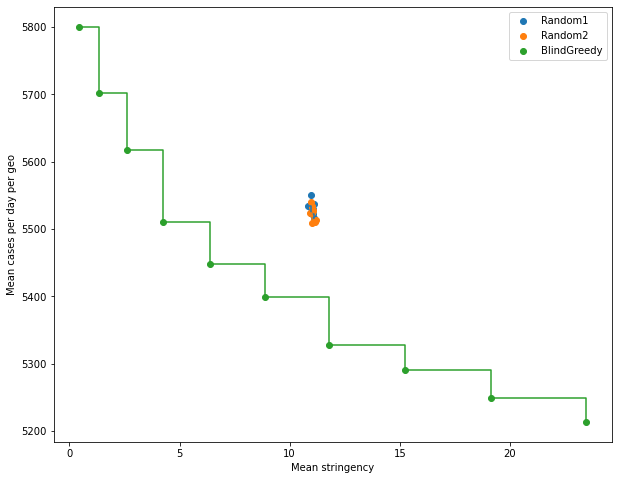

In [26]:
# Plot overall stringency and cases of each prescription
plt.figure(figsize=(10,8))
for prescriptor_name in prescription_files:
    pdf = df[df['PrescriptorName'] == prescriptor_name]
    overall_pdf = pdf.groupby('PrescriptionIndex').mean().reset_index()
    plt.scatter(overall_pdf['Stringency'],
                overall_pdf['PredictedDailyNewCases'], 
                label=prescriptor_name)
    plot_pareto_curve(list(overall_pdf['Stringency']),
                      list(overall_pdf['PredictedDailyNewCases']))
plt.xlabel('Mean stringency')
plt.ylabel('Mean cases per day per geo')
plt.legend()
plt.show()

<AxesSubplot:xlabel='Date', ylabel='Stringency'>

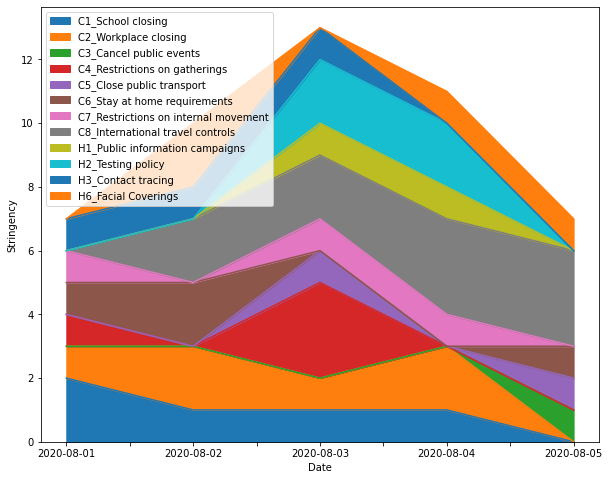

In [28]:
# Plot stacked line chart of npis over time for a prescription for a particular geo

#submission_file = 'covid_xprize.examples/prescriptors/neat/test_prescriptions/pres.csv'
submission_file = 'prescriptors/random/prescriptions/random_presc_1.csv'

prescription_index = 2
country_name = 'United States'
region_name = None

pdf = pd.read_csv(submission_file)
gdf = pdf[(pdf['PrescriptionIndex'] == prescription_index) &
          (pdf['CountryName'] == country_name) &
          (pdf['RegionName'].isna() if region_name is None else (pdf['RegionName'] == 'region_name'))]
gdf.plot.area(x='Date', y=NPI_COLS, figsize=(10,8), ylabel='Stringency')

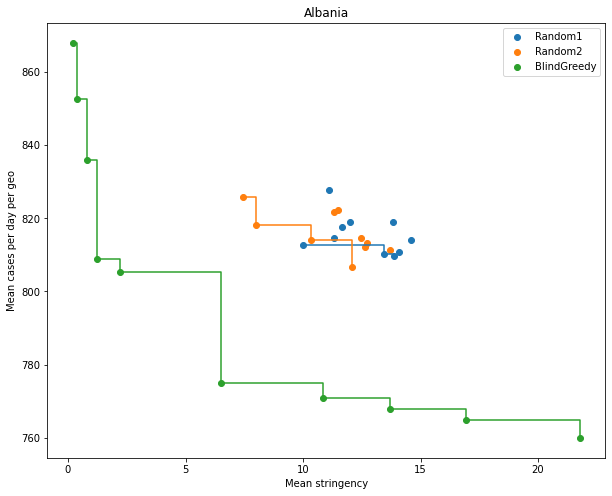

In [29]:
# Plot stringency and cases of each prescription for a particular country
country_name = 'Albania'
cdf = df[df.CountryName == country_name]

plt.figure(figsize=(10,8))
for prescriptor_name in prescription_files:
    pdf = cdf[cdf['PrescriptorName'] == prescriptor_name]
    #overall_pdf = pdf.groupby('PrescriptionIndex').mean().reset_index()
    plt.scatter(pdf['Stringency'],
                pdf['PredictedDailyNewCases'], 
                label=prescriptor_name)
    plot_pareto_curve(list(pdf['Stringency']),
                      list(pdf['PredictedDailyNewCases']))
plt.xlabel('Mean stringency')
plt.ylabel('Mean cases per day per geo')
plt.title(country_name)
plt.legend()
plt.show()